# Climate Change Belief Analysis
## Predict an individual’s belief in climate change based on historical tweet data - for EDSA Online

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies..

### Evaluation
The evaluation metric for this competition is Macro F1-Score. The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision p and recall r. Precision is the ratio of true positives (tp) to all predicted positives (tp + fp). Recall is the ratio of true positives to all actual positives (tp + fn).

#### Data Description

<img src='https://github.com/mrlondz/climate-change-edsa2020-21/blob/master/DataDescription.JPG?raw=True' width="600" height="100" align="left" >

## <font color=green>1. Import Libraries</font>

In [1]:
import pandas as pd # Data Frame Manipulation
import numpy as np
import re # Regular Expressions
from textblob import TextBlob # processing textual data
from autocorrect import Speller # Correct spelling of word
import nltk
from nltk.corpus import stopwords
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import spacy
nlp = spacy.load('en_core_web_sm') # Loading a model
import itertools #iterate through objects
from collections import OrderedDict 
from nltk.util import ngrams
from sklearn.metrics import classification_report # Classification report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

## <font color=green>2. Import the data</font>

In [2]:
df_test = pd.read_csv('https://raw.githubusercontent.com/mrlondz/climate-change-edsa2020-21/master/test.csv')
df_train = pd.read_csv('https://raw.githubusercontent.com/mrlondz/climate-change-edsa2020-21/master/train.csv')
sample_submission = pd.read_csv('https://raw.githubusercontent.com/mrlondz/climate-change-edsa2020-21/master/sample_submission.csv')
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


## <font color=green>3. Understanding the Data</font>

In [36]:
len(df_train)

15819


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
sentiment    15819 non-null int64
message      15819 non-null object
tweetid      15819 non-null int64
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [3]:
def rename_class(x): 
    """Rename the sentiments to get better analyse the data"""
    if x == 0:   return 'Neutral'       
    elif x == 1: return 'Pro'     
    elif x == 2: return 'News'    
    else: return 'Anti'            

In [4]:
# Label The sentiments
df_train.sentiment = df_train.sentiment.apply(rename_class)

#### Distribution of sentiments

AxesSubplot(0.125,0.125;0.775x0.755)


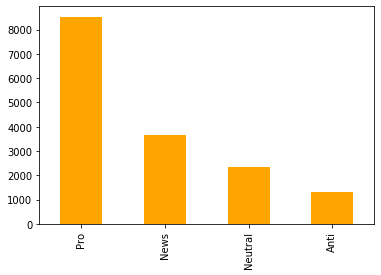

In [5]:
print(df_train.sentiment.value_counts().plot(kind='bar', color='orange'))

#### View Tweets

In [684]:
from colorama import Fore # Print Color Text

for sentiment, message, index in zip(df_train.sentiment, df_train.message, df_train.index):
    if index==2000: # Print the first 2000 tweets
        break
    elif sentiment == 'Pro':   
        print(f'{Fore.GREEN+sentiment}-{index}')
        print(f'{Fore.BLACK+message}\n')
    elif sentiment == 'Anti':
        print(f'{Fore.RED+sentiment}-{index}')
        print(f'{Fore.BLACK+message}\n')
    else:
        print(f'{Fore.BLUE+sentiment}-{index}')
        print(f'{Fore.BLACK+message}\n')

Pro-0
PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable

Pro-1
It's not like we lack evidence of anthropogenic global warming

News-2
RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…

Pro-3
#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD

Pro-4
RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight

Pro-5
Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j

Pro-6
RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R

Pro-7
RT @makeandmendlife: Six big things we can ALL do today to fight climate change, or how to be a climate activistÃ¢â‚¬Â¦ https://t.co/TYMLu6DbNM h


News-61
These House Republicans say climate change is real and it’s time to fight it | By @ninaburleigh
https://t.co/VnayFuHglW

Pro-62
But global warming is a hoax though. https://t.co/PZugB9WFWt

News-63
RT @kylegriffin1: NYT reviewed a draft climate change rpt by fed scientists directly contradicting the admin's global warming claims. https…

Neutral-64
RT @fuckofflaine: @jJxrry @SpaceX @QuebanJesus antarctica is so big lmao how is global warming real like nigga just use an Air conditioner

Pro-65
My two cents on the global political leadership on climate change in a trump era https://t.co/I60IQxYtY9

News-66
RT @BBCBreaking: UK government signs Paris Agreement, world's first comprehensive treaty on tackling climate change https://t.co/hDaFst5PFcÃ¢â‚¬Â¦

Neutral-67
RT @Hope012015: China tells Trump that climate change isn't a hoax it invented https://t.co/TX06PZXyzD via @business Lol, China schooling TÃ¢â‚¬Â¦

Pro-68
RT @MotherJones: Here are the races to watch if you care about gl


Pro-124
RT @lexi4prez: he is literally a climate change denier....RIP our planet https://t.co/B67IQ8N9Fs

Pro-125
@realDonaldTrump  what about climate change? It's very real but you only care about $$$$

Pro-126
RT @Kloppholic: Imagine trying to convince yourself that global warming isn't real and instead a conspiracy. Wake up, before it's tÃ¢â‚¬Â¦

Pro-127
@DocRock1007 So he IS saying climate change is a hoax, and every major scientific organization is a in on it?

Neutral-128
@PoliticalShort @piewagn Dems are causing global warming... #STFU

Anti-129
RT @signordal: New global warming study is terrible news for alarmists, good news for plants, animals an...https://t.co/KgJxLvfs7A https://…

Pro-130
Follow @projectARCC if you want to hear more about what A/V and digital archivists can do about climate change activism #AVhack16

Pro-131
If you don't believe in climate change, then look at the polar bears that are going extinct, because they have no land to live on.

News-132
Air pollut


Pro-189
RT @billmckibben: 'ExxonMobil has a long history of peddling misinformation on climate change.' @elizkolbert in @NewYorker #ExxonKnew https…

News-190
RT @pablorodas: #CLIMATEchange #p2 RT West Coast states to fight climate change even if Trump does not. https://t.co/dYixU8TxaK…

News-191
RT @EcoInternet3: U.S. Secretary of State, Rex Tillerson signs Arctic agreement for action on #climate change: Antinuclear https://t.co/7De…

News-192
Stephen Hawking has a message for Trump: Don't ignore climate change https://t.co/7bA3rBoHk9 https://t.co/uIQWwGz0pB

News-193
RT @telesurenglish: One of Jamaica’s iconic beaches is vanishing thanks to climate change. https://t.co/2lNoLT7MzM…

Pro-194
RT @MrDenmore: Apart from taking us to the brink of recession, doubling the deficit and making us a pariah on refugees &amp; climate change, th…

Anti-195
RT @Mike_Beacham: Fed scientist cooked climate change books ahead of Obama presentation 
#NoMoreSCAMS
#NoMoreDEMOCRATS
#DrainTheSwamp 
http…

P


Neutral-251
@JackPosobiec the global warming is caused by her cabbage farts

Anti-252
I was thinking the same thing. Same goes with climate change when there are other important issues that effect Amer… https://t.co/Hh1DoTQkhS

Neutral-253
RT @SimonWest26: Brilliant cartoon sums up @realDonaldTrump decision to cancel @BarackObama climate change policies! #itisreal…

Pro-254
RT @jamespeshaw: @NZGreens It gets you an end to poverty in New Zealand. It gets you clean water and action on climate change.

Neutral-255
Adam @adamcurry maakte al 923 keer zijn 'no agenda show' https://t.co/lnXz3YMwX7 

leuk! Info over 'global warming'… https://t.co/RFJ97WH8J2

Pro-256
RT @Shadbase: @Shadbase people who don't believe in global warming explain this

Pro-257
RT @BernieSanders: #ImVotingBecause the future of the planet is at stake. Hillary Clinton will combat climate change. Donald Trump thinks iÃ¢â‚¬Â¦

Anti-258
RT @Uniocracy: They'll tell you theyre doing it to save you from global warming. Theyr


Pro-313
RT @iansomerhalder: Speaking of climate change-TONIGHT Is another killer episode of @YEARSofLIVING ! 10/9c on @NatGeoChannel https://t.co/TÃ¢â‚¬Â¦

Pro-314
RT @BernieSanders: 'The concept of global warming was created by and for the Chinese in order to make U.S. manufacturing non-competitiÃ¢â‚¬Â¦

Pro-315
97 per cent of climate scientists believe climate change is real...#DonaldTrump thinks it's a Chinese hoax! Sad! https://t.co/btNlSthTog

Pro-316
EPA head suggests CO2 isn't a 'primary contributor' to climate change https://t.co/4uv8qQhqVb via @engadget C'mon!

Pro-317
RT @SenSanders: We have a president-elect who doesn't believe in climate change. Millions of people are going to have to say: Mr. TÃ¢â‚¬Â¦

Pro-318
NHLA supports efforts to combat climate change' @markmagana of #NHLAMember @GreenLatino #LatinoPriorities https://t.co/qWDeuju8bf

Pro-319
RT @ddlovato: #IVotedBecause I believe in equality, we need comprehensive immigration reform, I am pro-choice and global warmin


News-373
RT @AP_Politics: National Park Service defies White House social media ban, tweets on climate change, Japanese interned during WWII. https:…

Neutral-374
@3pointedit climate change triggers the rise of giant orchids which battle giant carniverous plants to devour the dwindling humans #thefilm

Pro-375
RT @SNVworld: Decentralised renewables: the front line against climate change https://t.co/ttIOtvzFMH via @Power4All2025 #COP22 #ClimateActÃ¢â‚¬Â¦

Neutral-376
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America, He is plaguing her
 
#FARRAKHAN #QUOTE

News-377
EPA chief: Carbon dioxide not 'primary contributor' to climate change https://t.co/YCNxXs1hET

Pro-378
RT @350: In the US? Write a letter to the editor, urge media to connect the dots between climate change &amp; Hurricane Harvey:…

Pro-379
Wisdom, courage needed in climate change fight | Sudbury Star https://t.co/DXx3UU5wrM - #climatechange

Pro-380
We may have even less tim


Pro-436
@WhosImmortal Worth a watch and I believe it has sincere intentions, but came off preachy to me, someone who believes climate change...

Pro-437
RT @StephenSchlegel: she's thinking about how she's going to die because your husband doesn't believe in climate change https://t.co/SjoFoNÃ¢â‚¬Â¦

Pro-438
The tomatoes are still fruiting and flowering in November. Mama's neighbour still thinks climate change is a lie. https://t.co/ggwPf0Jtrv

Pro-439
@thehill Summary:
Millionaires and billionaires, also global warming will kill us all

News-440
RT @guardiannews: Ã¢â‚¬ËœThereÃ¢â‚¬â„¢s no plan BÃ¢â‚¬â„¢: climate change scientists fear consequence of Trump victory https://t.co/wg2DfuT3WD https://t.co/LY2Ã¢â‚¬Â¦

Pro-441
Hunton/Weindorf explore climate change...villages in Alaska. Worth a view regardless of stance on cc. @KTTZ making an impact! @TexasTech

News-442
RT @MinhazMerchant: G7 environment ministers meet in Italy, pledge to fight climate change as per Paris accord with or witho


Anti-496
RT @PrisonPlanet: A bunch of Oxford elitists want to tax the food of poor people because 'climate change'. How about fuck off instead? httpÃ¢â‚¬Â¦

Pro-497
RT @Fusion: America is about to become the only country in the world with a leader who doesnÃ¢â‚¬â„¢t think global warming is real.Ã¢â‚¬Â¦

Pro-498
RT @DonnaFEdwards: Trumpian theory: if we don't research climate, then climate change won't exist. https://t.co/hWHsNecrhm

Neutral-499
@NuritBen if u ask me ? I say this is global warming position in real world ,as was ,in ranges are different ,trans eural ,India ,africa

News-500
Top climate change articles from last 48 hrs https://t.co/DnWNM9EGN0

Pro-501
RT @AltUSDA_ARS: Finally, the truth behind this Administration's tacit support of climate change! https://t.co/NJGVQtLXWo

Neutral-502
RT @jedrlee: Hey girl, are you climate change?
Because I'm going to ignore you until you fuck me.

Pro-503
RT @nowthisnews: The climate change 'hiatus' is bullish*t https://t.co/y1fKETHU3d




Pro-558
RT @JoyAnnReid: The next four years could set the United States back decades, in education, science, trade, climate change and more.

Pro-559
RT @teddygoff: Fun fact: if elected, Donald Trump would be the only leader of any nation on earth who denies climate change. https://t.co/9Ã¢â‚¬Â¦

Pro-560
RT @Mark_Butler_MP: 73% of Aussies want strong action on climate change &amp; energy because it will create jobs &amp; investment. #ClimateoftheNat…

Pro-561
RT @GreenpeaceUK: Nicola Sturgeon won't meet @realDonaldTrump while in USA, she'll sign agreement on climate change with Trump critic…

Pro-562
RT @keekin_it_real: it's really sad how some people still don't believe in climate change. the world is literally changing before your eyesÃ¢â‚¬Â¦

News-563
#NBC News - Posts | Trump dismissed man-made global warming a 'hoax' during... https://t.co/d5IjbHxJIT https://t.co/kHOscAOBoa

Pro-564
RT @mic: Watch misinformation about climate change be dispelled with real facts https://t.co/4hG1G


News-620
Germany, California to tackle climate change together https://t.co/dlb4hHDfgG

News-621
RT @CNN: President-elect Donald Trump says 'nobody really knows' if climate change is real https://t.co/0GAtmSMVZe https://t.co/i3tOPIFlG2

Pro-622
RT @BernieSanders: #ImVotingBecause the future of the planet is at stake. Hillary Clinton will combat climate change. Donald Trump thinks iÃ¢â‚¬Â¦

Anti-623
RT @USFreedomArmy: When will people understand this about globalism &amp; not global warming. Enlist ----&gt; https://t.co/oSPeY48nOh. Act!! https…

Pro-624
Imagine actually not believing in climate change even China believes in climate change

News-625
RT @cnni: The mental health implications of climate change https://t.co/VaBvPGyKt6 https://t.co/Kreu66e0Y6

Neutral-626
@classy_like_koi climate change man

Pro-627
RT @AAPsyc: Because Canadians believe in science and climate change! #WhyILoveCanada

Pro-628
@EmmanuelMacron Your Excellency the President：in response to your great climate chan


Pro-683
In the spirit of baru pulang liburan dr Bali, I urge every Indonesian who denies climate change to go there then google pics fr 10yrs ago

Pro-684
Add your sleep to the (long) list of things climate change might threaten. Recent research published in Science... https://t.co/zOlcJjtLdE

Neutral-685
Electromegnatic energy inthe AIR,(puja diya ko boojate hi,weather climate change AIR technologySE)hipnotize yourmind https://t.co/dGXvZZ2v84

News-686
Trump's energy staff can't use the words 'climate change': https://t.co/cUnUJ1su1e

Anti-687
RT @TwitchyTeam: New York Times 'slammed' with cancellations as punishment for climate change heresy https://t.co/uritRij1d6

Pro-688
Deforestation 2nd largest contributor to climate change #sxsw17 https://t.co/uuDMkJ6WH1

Pro-689
RT @cwebbonline: It's a crime that we went this whole election cycle with barely a mention of climate change! #BeforeTheFloodÃ¢â‚¬Â¦

Pro-690
Colbert mocks Trump for idiotic climate change comments .. https://t.co/tVg


Neutral-746
RT @pkollar: power rangers update: they're fighting a monster called the polluticorn. it's a unicorn that pollutes stuff. global warming pr…

News-747
RT climatehawk1: Biden urges Canada to fight #climate change despite Trump - ABCNews https://t.co/VVa5DqXKva #glo… https://t.co/ryQqRVtmnO

News-748
Trump to sign sweeping rollback of Obama-era climate change rules https://t.co/wo060qacTb https://t.co/usZ9ivjivk

Pro-749
RT @babysnitchery: guess what everyone high key knows climate change is real some people just don't give a shit bout ruining our planet to…

Pro-750
RT @DanRather: Slashing scientific research into climate change will not prevent our planet from warming. It will just mean we wil…

News-751
RT @HuffingtonPost: Energy deptartment rejects Trump's attempt to single out staff working on climate change https://t.co/k9QcaWjNAY https:…

Pro-752
Effects of global warming... Summers are getting harsher..Heat is increasing tremendously.. climate is becoming... https://


Pro-807
Our climate heroes of 2016 | Climate Home - climate change news https://t.co/slwPdIAlif

Anti-808
RT @ReaganTMan: Media falsely spins Trump's NYT climate comments - #Trump cited Climategate, restated skepticism of 'global warming' https:…

News-809
Canada announces new climate change goal: increase meetings by 88% by the year 2019... https://t.co/iktNR5XBeM

Anti-810
RT @NickDSmith74: Why are climate change fanatics so frightened of Lord Lawson.?

News-811
RT @dallasnews: Washington wants to restrict investor activism like @ExxonMobil climate change resolution | @JeffMosier https://t.co/XfjgS…

Pro-812
RT @maaaaaadiison: PSA the meat and dairy industry are the #1 contributor to climate change and deforestation

Neutral-813
Cali's 'endless global warming' drought over? How?
Storms are making a dent in California's drought; 7 feet of snow https://t.co/0OwWyxJf89

News-814
RT @climatehawk1: In Chile, many see #climate change as greatest external threat | @NPRParallels https://t.c


News-870
The US Republican spreading the conservative case for acting on climate change https://t.co/9yXZ92FYn5

News-871
Germany, California to tackle climate change together | Reuters #DemForce https://t.co/1lxccLsoyF

Pro-872
RT @jennmperron: This is so #Vermont; love it. A Vermont nature diary documents down-to-earth signs of climate change -Boston Globe https:/…

Pro-873
RT @bug_gwen: Read this *fantastic* piece on teaching kids climate change in conservative districts by @amy_harmon https://t.co/jBMzZ8WoOJ

Neutral-874
But, if climate change is real, how come there's. still many liberal snowflakes? #scienceisntreal (am I Tomi Lahren yet?)  ❄️

Pro-875
@BryanJFischer Seems like it's not a very complete analysis on climate change globally to only look at one spot, how about global sea ice?

Pro-876
@CNN Either we end our contribution to climate change or climate change will continue until it's powerful enough to… https://t.co/yuf4sahU5v

News-877
RT @CBCNews: Trump win a 'disaster


Neutral-931
Some r advocating a special role for central banks...using a ...range of instruments: climate change-related discl… https://t.co/FBqoq6wh0u

Neutral-932
Chemists find that spoiling series causes global warming

Pro-933
RT @SethMacFarlane: HRC proposes installing half a billion solar panels by the end of her first term. Trump thinks climate change is a hoaxÃ¢â‚¬Â¦

Anti-934
RT @ELDOBLEEM: Any scientist out there Still want to defend climate change? Both hoax inventors have run...
��ok lets focus on pic…

Neutral-935
RT @AllenWest: Bless her heart: Chelsea Clinton wades into the climate change debate on Twitter; it INSTANTLY backfires…

Pro-936
RT @foe_us: #ExxonKnew of the many risks of climate change and still spent years actively distorting the truth.…

Neutral-937
@WIRED Media already accused of missing the boat with the American electorate. Cool it, with the harping climate change Trump predictions!

News-938
RT @BelugaSolar: Donald Trump’s attitude towards climate chan


Pro-990
A high of 74 today the first day of November yep global warming is fake

Pro-991
RT @BloombergDotOrg: #ClimateofHope is a call to action for cities, where climate change is the harshest and solutions are most promisin…

Pro-992
RT @notarealnun: Please don't vote for the guy who doesn't believe in climate change, views women as objects and has an overall lack of jusÃ¢â‚¬Â¦

Pro-993
Population growth plus climate change equals disaster - The Herald-Times (subscription) https://t.co/uD8cXGFyw0

Pro-994
RT @jimwitkins: “Trump fools the New York Times on climate change” by @climateprogress https://t.co/sUfS3BO1ja #ActOnClimate

Pro-995
RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦

News-996
What do satellites tell us about climate change? https://t.co/3cIlT404BG via @YouTube

Pro-997
RT @richardbranson: Tackling climate change by changing the shipping, trucking, aviation and mining 


News-1053
RT @StanLeeGee: Scott Pruitt’s office deluged with angry callers after he questions the science of global warming https://t.co/ucXpudhBep

Pro-1054
RT @StephenSchlegel: she's thinking about how she's going to die because your husband doesn't believe in climate change https://t.co/SjoFoNÃ¢â‚¬Â¦

Pro-1055
So you want to buy a home in a global warming zone. RonLieber explains how to assess the risk you’re taking on. https://t.co/CkEWCw0CF6

News-1056
Defy 'Stalinist' global warming rules and burn much more coal, says Trump's key economic adviser
 
https://t.co/pDCWgmyyKN

Pro-1057
Sen. Gillibrand up now. It's her turn to bring up climate change.

News-1058
How #UN #BigData initiative could help fight climate change https://t.co/i09Z4iMo2H @WDCreators https://t.co/GDzW0Xj9dk

Pro-1059
RT @SenSanders: We have a president-elect who doesnÃ¢â‚¬â„¢t believe in climate change. ThatÃ¢â‚¬â„¢s frightening for this country and the world.

Neutral-1060
RT @EricBoehlert: number of times 'cl


Neutral-1176
RT @CivilJustUs: How do they expect us to care about global warming with all this penguin on penguin crime?? https://t.co/HypysWHvVV

Pro-1177
Today @HIT_trentino discussing research and innovation for climate change with @Climate-KIC. #climatechange… https://t.co/85bra9Ijro

Anti-1178
@Morning_Joe @JoeNBC Fake news is when you say man is causing global warming and $15 min wage doesn't cost jobs. You libs are clueless!!

News-1179
RT @FAOMozambique: New #UNFAO project on climate change may benefit 1800 households-#readon- https://t.co/kRZeZR44ek https://t.co/JKfg1sGQlB

News-1180
Earth Hour plunges world into darkness to fight climate change https://t.co/yLOoACTLRR

Pro-1181
Climate deniers blame global warming on nature. This NASA data begs to differ https://t.co/bDxJESwnlx

Anti-1182
RT @PrisonPlanet: A bunch of Oxford elitists want to tax the food of poor people because 'climate change'. How about fuck off instead? httpÃ¢â‚¬Â¦

Pro-1183
@komputernik Could make $ sellin


Pro-1237
RT @PaulHindley2210: Sorry Paul Nuttall, most working class voters are not homophobic, anti-abortion, climate change deniers who want to pr…

Anti-1238
RT @PrisonPlanet: Anyone lecturing me about the 'science' behind global warming who simultaneously thinks there are more than two genders c…

News-1239
RT @Jmalewitz: As ExxonMobil CEO, Rex Tillerson used the pseudonym 'Wayne Tracker' in climate change-related emails, NY AG says https://t.c…

News-1240
Canada's northernmost community seeks PM's help to weather climate change https://t.co/URSqhL2E03 https://t.co/02gmWhumVq

Anti-1241
RT @Heritage: President Trump must resist pressure from foreign leaders to cave in on global warming. https://t.co/3SpvjhCpu7

News-1242
RT @YahooNews: Billionaire climate change activist says heÃ¢â‚¬â„¢ll spend whatever it takes to fight Trump https://t.co/9PxJKpE4hR https://t.co/8Ã¢â‚¬Â¦

Pro-1243
RT @JonRiley7: I've always thought this! How can you distrust scientists (on stuff like climate chan


News-1297
RT @flynotes3: Arctic ice melt could trigger uncontrollable climate change at global level https://t.co/qQwXcrXVIE

News-1298
RT @Reuters: In rare move, China criticizes Trump plan to exit climate change pact https://t.co/XM7qUmahdX https://t.co/NA2yg8JkP9

Pro-1299
RT @imasian28: Our president don't believe global warming so https://t.co/DuqpO4MNXI

Pro-1300
76 on November 1st? Fuck this shit if you don't think climate change is real, wake the fuck up

Neutral-1301
RT @jyoungwhite: good morning to pineapple pizza eaters only. the rest of y'all are responsible for global climate change &amp; amy schumer

Pro-1302
RT @KimBrownTalks: calling shale gas a 'bridge fuel' is a sure way not to get my vote. bcuz that shows me you're not taking climate changeÃ¢â‚¬Â¦

Pro-1303
1. Another huge blow to the world. A climate change denialist gets hired to head up the Environmental Protection Agency. #TrumpPresident

Pro-1304
RT @andrea_portes: @TomiLahren Conservative logic: Let's keep usi


Pro-1358
RT @Bro_Pair: We're going to need leaks for basic info on food safety &amp; climate change, which will mean prosecution of scientists: https://…

Anti-1359
It's really not about science at all, but religious fundamentalism of the climate change cult. With a sprinkling of… https://t.co/vV8L1zTsGq

News-1360
RT @CNN: Depression, anxiety, PTSD: The mental impact of climate change https://t.co/zjInwo5l8j https://t.co/tyAJeHx6Br

Pro-1361
RT @WSJ: Opinion: We need to consider how much economic damage climate change will do, write David Henderson &amp; @JohnHCochrane https://t.co/…

News-1362
[national]:Scientists explore impact of global warming on Japan's sea life https://t.co/CStF19DnnP

Anti-1363
RT @MarkACollett: The biggest threat to the environment isn't global warming, it's overpopulation that is fuelled by liberal aid to the thi…

Pro-1364
Today at 8.30pm it's #EarthHourUK! Make sure you turn off your lights to address the global issue of climate change https://t.co/rbKbYm


Neutral-1418
RT @ElisabethHoll17: Talking about climate change https://t.co/2GyCvrl6uh

News-1419
Mitigating climate change after wildfire https://t.co/mGn6KwMgmW via @asheville

News-1420
RT @mattiwaananen: Donald Trump wants to shut off an orbiting space camera that monitors climate change https://t.co/HNYWkxkemn

News-1421
RT @PostOpinions: Reader Anne Hubbard on climate change: 'These are not partisan issues. These are human issues.'…

Pro-1422
Interested in being part of community action on climate change? This is the event for you! https://t.co/akxvfGcJe6

News-1423
RT @business: Meet @AmberSullins, the red-state weatherwoman on a climate change mission https://t.co/h81ub2WYuA via @climate https://t.co/…

News-1424
RT @NoamLevey: HHS pick Tom Price refuses to say that human activity is responsible for climate change. Needs to be studied, he tells @SenW…

Pro-1425
RT @RBReich: Trump’s new EPA administrator Scott Pruitt is already filling the agency with climate change deniers.…




Pro-1480
With Trump as president, ChinaÃ¢â‚¬â€China!Ã¢â‚¬â€will be the world's biggest champion of fighting climate change - Quartz https://t.co/FmLY62ZXIj

Neutral-1481
@IvankaTrump paid family leave, lgbtqlmnopqrs rights, climate change, women empowerment, great platform as a democrat....

Pro-1482
RT @am_anatiala: #FF @EricHolthaus &amp; read this b/c we 👏🏽 can 👏🏽 not 👏🏽 depend on the govt to lessen the effects of climate change. https://…

News-1483
RT @ClimateCentral: The balance of power is shifting for who is leading the world on climate change action https://t.co/wBdZuP7mHz https://…

News-1484
RT @Independent: Donald Trump team asks for list of Department of Energy workers who have attended climate change talks https://t.co/vD15Mu…

News-1485
Global green movement prepares to fight Trump on climate change https://t.co/ORZo8jjTQa

News-1486
Government scientists say climate change could wipe out U.S. coral reefs in just a few decades. https://t.co/NcQE8Q8qF4

News-1487
RT @n


Pro-1602
RT @RogueSNRadvisor: Pres' stance on climate change will go down as the worst aspect of his presidency - and that's saying something. Disgr…

Anti-1603
RT @ScientistTrump: It's 30º (really cold) in New York  today - tell the so-called 'scientists' that we want global warming right now!…

Pro-1604
RT @earthislandjrnl: Rebounding #wolverine populations in #PacificNorthwest contend with reduced #habitat connectivity, #climate change htt…

Pro-1605
RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦

News-1606
Climate change a Chinese hoax? Beijing gives Donald Trump a history lesson: China points out to global warmingÃ¢â‚¬Â¦ https://t.co/P7vu5faVwo

News-1607
RT @bpolitics: Tillerson used email alias 'Wayne Tracker' at Exxon to talk climate change, New York AG says https://t.co/rKINESFq2q https:/…

Pro-1608
The only good thing about global warming is that there will be less Florida to 


News-1661
RT @SafetyPinDaily: The global reaction to Trump's climate change decision | By @ariabendix https://t.co/BdsttMmild

Pro-1662
RT @1LaurenRussell: Get queasy when I hear people debate about climate change. It's not debatable so why do we humor the discussion?

Pro-1663
RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦

Pro-1664
RT @greenroofsuk: Melting glaciers caught in incredible time-lapse photographs show #climate change in action https://t.co/qmv3COQdWq #env…

Pro-1665
It's #2016 and I can't believe people still don't believe in climate change its effing science.

Pro-1666
RT @EddyJokovich: Turnbull to take the lead on economy from the Treasurer. Destroying the #NBN and climate change policy isn't enough? #lat…

Pro-1667
But I guess global warming isn't real, right? https://t.co/ui5Sa5psuJ

Pro-1668
RT @WhiteHouse: Last year, @POTUS visited the Arctic to see the impact of cl


Pro-1722
RT @energyenviro: Arctic ice retreat caused by climate change has killed 80,000 reindeer - https://t.co/dqAEy0zeET #ClimateChange #reindeers

News-1723
RT @IUCN: Mangroves and marshes are key in the climate change battle https://t.co/6pkf8rchgI #WorldWetlandsDay https://t.co/nypUoFupxY

Pro-1724
RT @ChaosChanges: Good to see Al Gore back with a sequel to put climate change back on the agenda. Do the world a favour and RT https://t.c…

Anti-1725
@buterastrology global warming is a myth and the holocaust is fake and never happened open your eyes to the truth people wake up

Pro-1726
RT @ClimateCentral: This map shows who is leading the world (and who is faltering) on climate change action https://t.co/2vNtpssugB https:/…

Pro-1727
@SamanthaJPower @ParentofSam1 America is joining wacky climate change deniers. Perhaps @realDonaldTrump will join the flat earth society.

Pro-1728
RT @vastleft: Poor climate change. It deserved to be ignored by a president who believes it exists.

Ne


Pro-1783
RT @wef: Why China and California are trying to work on #climate change without Trump https://t.co/aL8QLR0iOD https://t.co/6UHEbZSo0U

Pro-1784
RT @SenSanders: While Mr. Trump and his cabinet nominees deny the reality of climate change, people throughout the world are suffering and…

Pro-1785
The global warming signal in the Arctic was stronger and more pronounced during 2016 than any other year… https://t.co/S913cp6AAi

News-1786
Company directors can be held legally liable for ignoring the risks from climate change https://t.co/Sg44XkCkXl vÃƒÂ­a @ConversationUS

Pro-1787
RT @CNN: No snow where there should be. Bleached anemones. Cracks in the ice. This is what climate change looks like:Ã¢â‚¬Â¦

Pro-1788
RT @pATREUS: Neoliberalism has conned us into fighting climate change as individuals | Martin Lukacs https://t.co/0DiyfqHPWc

News-1789
Reports on climate change have disappeared from the State Department website https://t.co/gpMKnvktN4

Anti-1790
@NewDay @ChrisCuomo 7 out o


News-1842
RT @ClimateUC: News on climate change science and clean energy solutions. Curated by the University of California, a national leader in sus…

Pro-1843
The Trump administration's solution to climate change: ban the term

https://t.co/v0RP33CL9I

News-1844
RT @tutticontenti: Penguins quickly disappearing from Antarctica due to climate change https://t.co/qYi8fV86qd

Pro-1845
RT @leahmcelrath: A friend and classmate at @smithcollege, @BrendaEkwurzel, speaks truth to power about climate change:

������
#RESIST
https:…

Pro-1846
RT @TwitterMoments: A study found that Exxon went against internal findings to publicly downplay climate change dangers to the public. http…

News-1847
Vatican says Trump risks losing climate change leadership to China https://t.co/QlXvrS4jTM

News-1848
RT @snowleopards: 35% of snow leopard habitat can be considered safe from climate change - October eNews - https://t.co/4w2aYQMQX6

Pro-1849
Guys, we don't need to worry about Florida anymore bc global war


Pro-1904
RT @AnaKasparian: Neil DeGrasse Tyson slams climate change deniers amid Hurricane Harvey https://t.co/WvQFDxq1DT

Pro-1905
RT @ChrisJZullo: #DearPresident climate change is not Chinese scam like Breitbart's Steve Bannon would tell you. 2016 set to be the hottestÃ¢â‚¬Â¦

Pro-1906
Malta is my main ancestral homeland. Stupid climate change... https://t.co/yjYJztGSBC

Pro-1907
@Alberta411 @TheStreet That company doesn't believe in Climate Change. They're one of the biggest opponents of any US climate change policy

News-1908
RT @guardian: Trump picks climate change sceptic Scott Pruitt to lead EPA https://t.co/ElVpcH7gLg

Pro-1909
RT @BernieSanders: #ImVotingBecause the future of the planet is at stake. Hillary Clinton will combat climate change. Donald Trump thinks iÃ¢â‚¬Â¦

Pro-1910
RT @Mikel_Jollett: For decades, climate scientists have been predicting that man-made climate change would increase the intensity of hurric…

Pro-1911
RT @SueForMayor: Investors worth $2.8 trillion 


Pro-1964
.@StephenLloydEBN pls publicly oppose DUP views on abortion, same-sex-marriage + climate change #DUPdeal

Neutral-1965
Lol mfs literally don't believe in global warming that's sick as hell

Pro-1966
I just joined @NatGeoChannel @21CF in combating climate change. Take action #BeforeTheFlood
https://t.co/1ipV7kcdy5

Neutral-1967
@cathmckenna @ParksCanada Below temperature in the gta. No global warming here.

Neutral-1968
RT @SimonBanksHB: 4 years of LNP energy and climate change policy #QandA:

Electricity prices UP

Carbon emissions UP

Energy insecurity UP…

News-1969
RT @thehill: National park deletes viral climate change tweets that defied Trump social media ban: https://t.co/DCUL60CyZo https://t.co/HgI…

Pro-1970
Energy Department climate change office bans ‘climate change’ language — yes, you read that right https://t.co/TZyFFgcHgB via @theblaze

News-1971
How will climate change affect pensions? - Hamilton Spectator https://t.co/i3INJPViVm https://t.co/zqmw6gxMfq

Neutra

## <font color=green>4. Data Preprocessing</font>

#### Missing Values

In [47]:
df_train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

#### Blank Tweets

In [53]:
blanks = []  # start with an empty list

for i,lb,rv in df_train.drop("tweetid", axis=1).itertuples():  # iterate over the DataFrame
    if type(rv)==str:            # avoid NaN values
        if rv.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


#### Processing Functions

In [6]:
def lower_case(tweet):
    """returns tweet in lower case"""
    return "".join(tweet.lower())

def remove_punctuation(tweet):
    """returns tweet without punctuations"""
    return re.sub(r'[^\w\s]', '', tweet)

def remove_stopwords(tweet):
    """removes stopwords from tweet"""
    return " ".join(word for word in tweet.split() if word not in stopwords.words('english'))

# Standardising Text
def replace_slangwords(tweet):
    """replace slang words with normal speech"""
    
    slang_words = {'pic':"picture", 'u':"you", 'haha':"laughing", 'lol':"laughing out loud", 'btw':"by the way",
                   'lmao':"laughing my ass off", 'tbh':"to be honest",'jk':"just joking", 'lmk':"let me know", 
                   'omg':"amazing", 'ppl':"people", 'smh':"shaking my head",'idk':"i don't know", 'rn':"right now",
                   'bc':"because", 'w':"with", 'chnge':"change", 'c':"see", 'fyi':"for your information"}
        

    new_tweet = []
    for word in tweet.split():
        if word.lower() in slang_words:
            word = slang_words[word.lower()]
        new_tweet.append(word)
    
    return ' '.join(word for word in new_tweet)    

def correct_spelling(tweet):
    """autocorrects mispelled words in tweet"""
    spell = Speller()
    
    return ' '.join(spell(word) for word in tweet.split())


stemmer = SnowballStemmer('english') # define stemmer function
tokeniser = TreebankWordTokenizer() # tokenise data
lemmatizer = WordNetLemmatizer() # define lemmatiser

def tokenize_tweet(tweet):
    return tokeniser.tokenize(tweet)
    
def stem_tweet(tweet):
    return ' '.join(stemmer.stem(word) for word in tweet.split())
       
def lemmatize_tweet(tweet):
    return ' '.join(lemmatizer.lemmatize(word) for word in tweet.split())

# Replace Emojis in a tweet
import demoji # emoji library
demoji.download_codes()

all_emojis = demoji.findall(' '.join(tweet for tweet in df_train.message))

def replace_emojis(tweet):
    """Replace the emojis in a tweet with their actual meaning"""
    new_tweet = []
    for word in tweet.split():
        if word in all_emojis:
            word = all_emojis[word]
        new_tweet.append(word)
    
    return ' '.join(word for word in new_tweet)

... OK (Got response in 0.68 seconds)
Writing emoji data to C:\Users\lk0711\.demoji\codes.json ...
... OK


#### Clean Tweets

In [7]:
def process_tweet(tweet, lower=False):
    
    """Returns processed and cleaned tweet, can be lower case if lower=True"""
    
    tweet = replace_emojis(tweet)
    tweet = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', tweet) #Removes unicode strings like "\u002c" and "x96"
    tweet = re.sub(r'[^\x00-\x7f]',r'',tweet)       #Removes unicode strings like "\u002c" and "x96"
    tweet = replace_slangwords(tweet)               #Replace slang words
    #tweet = correct_spelling(tweet)                 #Correct Spelling of words in tweet
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet) #Convert any url to URL  
    tweet = re.sub('@[^\s]+','AT_USER',tweet)   #Convert any @Username to "AT_USER"
    tweet = re.sub('[\s]+', ' ', tweet)         #Remove additional white spaces
    tweet = re.sub('[\n]+', ' ', tweet)         #Remove additional white spaces  
    tweet = re.sub(r'[^\w]', ' ', tweet)        #Remove not alphanumeric symbols white spaces    
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)                     #Removes hashtag in front of a word """   
    tweet = tweet.replace(':)',''); tweet = tweet.replace(':(','') #Remove :( or :)
    tweet = ''.join([i for i in tweet if not i.isdigit()])         #Remove numbers
    tweet = re.sub(r"(\!)\1+", ' ', tweet)     #Remove multiple exclamation 
    tweet = re.sub(r"(\?)\1+", ' ', tweet)     #Remove multiple question marks
    tweet = re.sub(r"(\.)\1+", ' ', tweet)     #Remove multistop     
    #tweet = stem_tweet(tweet) # stemmer
    tweet = lemmatize_tweet(tweet) # lemmatizer
    tweet = " ".join(word for word in tweet.split() if word not in stopwords.words('english')) #Remove stop words
    #Removes emoticons from text
    tweet =  re.sub('[(\U0001F600-\U0001F92F|\U0001F300-\U0001F5FF|\U0001F680-\U0001F6FF|\U0001F190-\U0001F1FF|\U00002702-\U000027B0|\U0001F926-\U0001FA9F|\u200d|\u2640-\u2642|\u2600-\u2B55|\u23cf|\u23e9|\u231a|\ufe0f)]+','',tweet)
    tweet = tweet.strip('\'"') #trim  
    if lower:
        tweet = tweet.lower() #Lower case

    return tweet

#### Sample Tweet

In [9]:
sample_tweet = 'RT @MissLizzyNJ Don''t Lmao "user" 😂 !!!!!! snowflakes ❄️ complaining about snowflakes ❄️ in winter =global warming 🤦\u200d♂️RT @thenation: #ClimateChange Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R'
print(f'{sample_tweet}\n')
print(process_keywords(process_tweet(sample_tweet)))

RT @MissLizzyNJ Dont Lmao "user" 😂 !!!!!! snowflakes ❄️ complaining about snowflakes ❄️ in winter =global warming 🤦‍♂️RT @thenation: #ClimateChange Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R

RT AT_USER Dont laughing user face tear joy snowflake snowflake complaining snowflake snowflake winter global warming RT AT_USER climate change Mike Pence doesnt believe global warming smoking cause lung cancer URL


## <font color=green>5. Data Analysis</font>

#### Analysis on words

In [724]:
def get_all_words(df):
    """Returns all words in all the tweets after tweet is processed"""
    tweet_words = []
    for tweet in df.message.apply(process_tweet):
        for word in tweet.split():
            tweet_words.append(word.lower())                                       
    return tweet_words

In [725]:
all_words = get_all_words(df_train) # Get all the words in all the tweets
all_words_pro = get_all_words(df_train[df_train.sentiment=='Pro']) # Get the words from the Pro tweets
all_words_neutral = get_all_words(df_train[df_train.sentiment=='Neutral']) # Get the words from the neutral tweets
all_words_anti = get_all_words(df_train[df_train.sentiment=='Anti']) # Get the words from the Anti tweets
all_words_news = get_all_words(df_train[df_train.sentiment=='News']) # Get the words from the News tweets

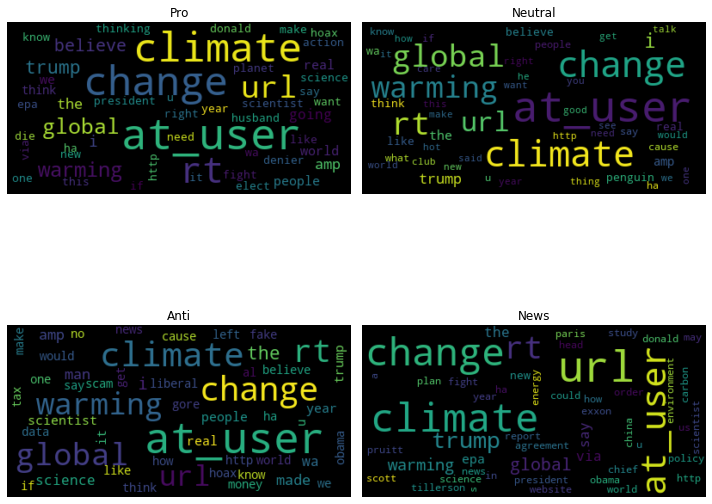

In [1211]:
words_sentiment = [all_words_pro, all_words_neutral, all_words_anti, all_words_news]
sentiments = ['Pro', 'Neutral', 'Anti', 'News']

"""Display Frequency or the importance of each word"""

fig=plt.figure(figsize=(10,10))
x = range(4)
for word_list, sent, a in zip(words_sentiment, sentiments, x):
    wcloud = WordCloud(max_font_size=50, max_words=50).generate_from_frequencies(FreqDist(word_list))
    ax = fig.add_subplot(2,2,1+a) 
    ax = ax.title.set_text(sent)
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis("off")
fig.tight_layout()
plt.show()

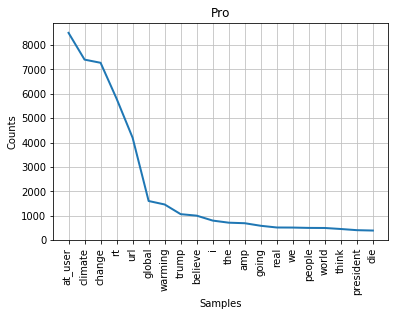

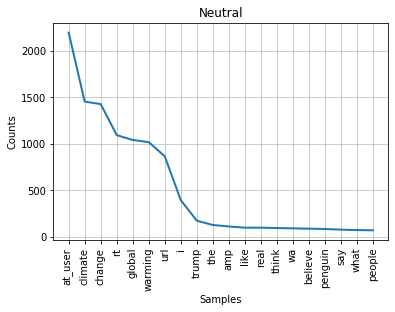

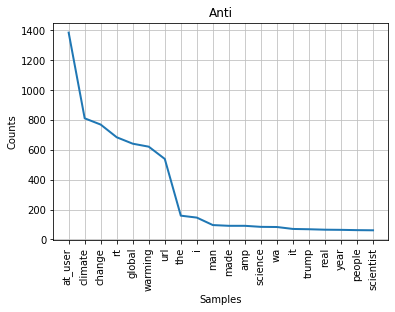

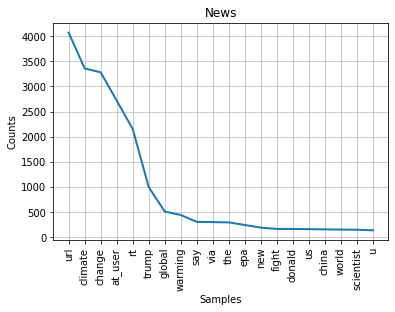

In [1212]:
words_sentiment = [all_words_pro, all_words_neutral, all_words_anti, all_words_news]
sentiments = ['Pro', 'Neutral', 'Anti', 'News']

"""Display Frequency of top 20 words for each sentiment"""

plt.ion()
x = range(4)
for word_list, sent, a in zip(words_sentiment, sentiments, x):
    frequency_dist = FreqDist(word_list)
    #ax = fig.add_subplot(2,2,1+a) 
    #ax = ax.title.set_text(sent)
    FreqDist(frequency_dist).plot(20,cumulative=False, title=sent)
    #plt.axis("off")
#fig.tight_layout()
plt.ioff()
plt.show()

In [763]:
frequency_dist = FreqDist(all_words)
frequency_dist

FreqDist({'at_user': 14788, 'climate': 13017, 'change': 12742, 'rt': 9724, 'url': 9668, 'global': 3798, 'warming': 3544, 'trump': 2303, 'i': 1367, 'the': 1300, ...})

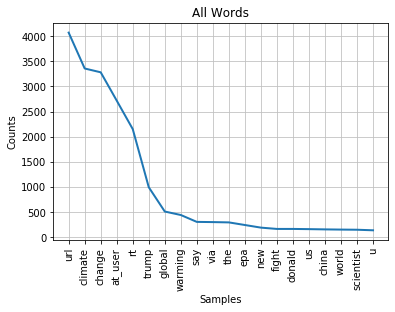

In [1213]:
"""Display Frequency for top 20 words overal"""

sorted_frequency_dist = sorted(frequency_dist,  reverse=False)
FreqDist(frequency_dist).plot(20,cumulative=False, title='All Words')

#### Process Keywords from tweet

In [8]:
def process_keywords(tweet):
    
    """Process Key words from tweet (most frequent and important words)"""
    
    tweet = tweet.split()
    tlen = len(tweet)
    for i, word in zip(range(tlen), tweet):   
        if word.lower()[0:8] == 'climatec':     
            tweet[i] = 'climate change'
        elif word.lower()[0:7] == 'climate' and word.lower()[1:9] != 'climatec':
            tweet[i] = 'climate'
        elif word.lower()[0:7] == 'globalw':
            tweet[i] = 'global warming'
        elif word.lower()[0:6] == 'global' and word.lower()[0:7] != 'globalw':
            tweet[i] = 'global'
        elif word.lower()[0:7] == 'donaldt':
            tweet[i] = 'donald trump'
        elif word.lower()[0:5] == 'trump':
            tweet[i] = 'trump'
        elif word.lower()=='http':
            tweet[i] = 'url'
    return ' '.join(word for word in tweet)                  

#### Sentiment Analysis

In [10]:
#Functions to get sentiments from tweets

def tweet_subjectivity(tweet): 
    """Functions tells how subjective or opinionated the tweet is"""  
    tweet = replace_emojis(tweet)
    score = round(TextBlob(tweet).sentiment.subjectivity, 1)
    
    if score < 0.3:
        return 'Fact'
    else:
        return 'Opinion' 

def tweet_polarity(tweet):  
    """Functions tells how positive or negative the text is"""  
    tweet = replace_emojis(tweet)
    score = round(TextBlob(tweet).sentiment.polarity, 2)
    
    if score < 0:
        return 'Negative'
    elif score == 0.00:
        return 'Neutral'
    else:
        return 'Positive'   

In [15]:
df_train["Subjectivity"] = df_train.message.apply(tweet_subjectivity)
df_test["Subjectivity"] = df_test.message.apply(tweet_subjectivity)

df_train["Polarity"] = df_train.message.apply(tweet_polarity)
df_test["Polarity"] = df_test.message.apply(tweet_polarity)

In [16]:
df_train.head()

,sentiment,message,tweetid,Subjectivity,Polarity
0,Pro,PolySciMajor EPA chief doesn't think carbon di...,625221,Fact,Positive
1,Pro,It's not like we lack evidence of anthropogeni...,126103,Fact,Neutral
2,News,RT @RawStory: Researchers say we have three ye...,698562,Opinion,Negative
3,Pro,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,Opinion,Positive
4,Pro,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,Fact,Neutral


In [17]:
df_train.groupby(by='sentiment')['Polarity'].value_counts()

sentiment  Polarity
Anti       Neutral      594
           Positive     368
           Negative     334
Neutral    Neutral     1107
           Positive     829
           Negative     417
News       Neutral     2197
           Positive     858
           Negative     585
Pro        Neutral     3678
           Positive    3214
           Negative    1638
Name: Polarity, dtype: int64

##### - Neutral and News tweets are majority neutral views

## <font color=green>6. Feature Engineering</font>



#### Process and clean tweets

In [11]:
df_train["Tweet"] = df_train.message.apply(process_tweet, lower=True).apply(process_keywords)
df_test["Tweet"] = df_test.message.apply(process_tweet, lower=True).apply(process_keywords)

In [19]:
df_train.head(3)

,sentiment,message,tweetid,Subjectivity,Polarity,Tweet
0,Pro,PolySciMajor EPA chief doesn't think carbon di...,625221,Fact,Positive,polyscimajor epa chief think carbon dioxide ma...
1,Pro,It's not like we lack evidence of anthropogeni...,126103,Fact,Neutral,it like lack evidence anthropogenic global war...
2,News,RT @RawStory: Researchers say we have three ye...,698562,Opinion,Negative,rt at_user researchers say three year act clim...


#### Transform Tweet into features using TfidfVectorizer

In [12]:
tfidf_vect = TfidfVectorizer(token_pattern=r'\w{1,}',ngram_range=(1,2), max_features=100000, stop_words=['a'])
tfidf_vect.fit(df_train.Tweet)

X = tfidf_vect.transform(df_train.Tweet)
y = df_train.sentiment

le = LabelEncoder() # Encode classes

y = le.fit_transform(y) 

type_labels = list(le.classes_)

#### Balance the Data

AxesSubplot(0.125,0.125;0.775x0.755)


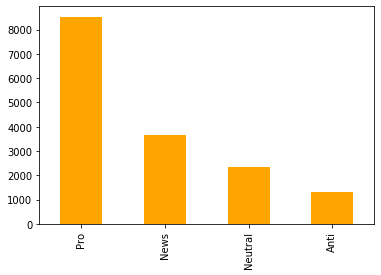

In [46]:
print(df_train.sentiment.value_counts().plot(kind='bar', color='orange'))

#### Over-sampling followed by under-sampling

In [13]:
smt = SMOTETomek()
X_smt, y_smt = smt.fit_sample(X, y)

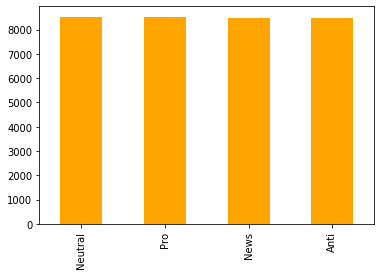

In [14]:
pd.DataFrame(y_smt)[0].apply(rename_class).value_counts().plot(kind='bar', color='orange')

## <font color=green>7. Model Building</font>

#### Split data into test and train

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size=0.2, random_state=28)

#### Build Model

In [16]:
def model_results(model):
    """Returns confusion matrix for given model using global train and valid data """
    
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test) # Prediction
    return print(classification_report(y_test, y_pred_test, target_names=type_labels))

## <font color=green>8. Model Evaluation</font>

#### Logiistic Regression

In [105]:
lr_model = LogisticRegression(solver='saga', multi_class='multinomial')
model_results(lr_model)

              precision    recall  f1-score   support

        Anti       0.95      0.98      0.96      1727
     Neutral       0.91      0.91      0.91      1719
        News       0.88      0.94      0.91      1686
         Pro       0.87      0.79      0.83      1680

    accuracy                           0.90      6812
   macro avg       0.90      0.90      0.90      6812
weighted avg       0.90      0.90      0.90      6812



#### RandomForrest Classifier

In [44]:
rf_model = RandomForestClassifier(n_estimators=1500, max_features='log2')
model_results(rf_model)

              precision    recall  f1-score   support

        Anti       1.00      0.98      0.99      1649
     Neutral       0.95      0.96      0.95      1714
        News       0.95      0.93      0.94      1741
         Pro       0.88      0.91      0.90      1720

    accuracy                           0.94      6824
   macro avg       0.95      0.94      0.94      6824
weighted avg       0.94      0.94      0.94      6824



#### AdaBoostClassifier

In [81]:
abc_model = AdaBoostClassifier()
model_results(abc_model)

              precision    recall  f1-score   support

        Anti       0.79      0.51      0.62      1687
     Neutral       0.53      0.65      0.58      1661
        News       0.67      0.82      0.73      1742
         Pro       0.58      0.52      0.55      1722

    accuracy                           0.63      6812
   macro avg       0.64      0.63      0.62      6812
weighted avg       0.64      0.63      0.62      6812



#### Support Vector Machine 

In [188]:
svc_model = LinearSVC(C=10)
model_results(svc_model)

              precision    recall  f1-score   support

        Anti       0.97      1.00      0.98      1727
     Neutral       0.95      0.97      0.96      1719
        News       0.93      0.97      0.95      1686
         Pro       0.94      0.85      0.89      1680

    accuracy                           0.95      6812
   macro avg       0.95      0.95      0.95      6812
weighted avg       0.95      0.95      0.95      6812



#### Support Vector Machine Non-Linear

In [161]:
svc_model_2 = SVC(C=100, gamma=0.01)
model_results(svc_model_2)

              precision    recall  f1-score   support

        Anti       0.98      1.00      0.99      1727
     Neutral       0.95      0.97      0.96      1719
        News       0.93      0.96      0.94      1686
         Pro       0.92      0.86      0.89      1680

    accuracy                           0.95      6812
   macro avg       0.95      0.95      0.95      6812
weighted avg       0.95      0.95      0.95      6812



#### Naive Bayes

In [83]:
nb_model = MultinomialNB()
model_results(nb_model)

              precision    recall  f1-score   support

        Anti       0.89      0.98      0.94      1687
     Neutral       0.87      0.92      0.90      1661
        News       0.84      0.96      0.89      1742
         Pro       0.94      0.65      0.76      1722

    accuracy                           0.88      6812
   macro avg       0.88      0.88      0.87      6812
weighted avg       0.88      0.88      0.87      6812



#### KNeighborsClassifier

In [85]:
kn_model = KNeighborsClassifier()
model_results(kn_model)

              precision    recall  f1-score   support

        Anti       0.76      0.99      0.86      1687
     Neutral       0.65      0.96      0.78      1661
        News       0.83      0.89      0.86      1742
         Pro       0.99      0.17      0.29      1722

    accuracy                           0.75      6812
   macro avg       0.81      0.75      0.70      6812
weighted avg       0.81      0.75      0.70      6812



#### K-fold Cross Validation

In [198]:
from sklearn.model_selection import KFold

def ave_model_score(model):
    
    """Takes model and returns average score for that model"""

    model_list = [] # List of models to chose from
    model_scores = [] # List of RMSEs from corresponding models
    
    kfold = KFold(n_splits=10) # Use 10 folds

    for train_index, test_index in kfold.split(X_smt):

        X_train, X_test, y_train, y_test = X_smt[train_index], X_smt[test_index], y_smt[train_index], y_smt[test_index]

        # train model
        model.fit(X_train,y_train)
        model_list.append(model)

        # model score
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        model_scores.append(f1)   
    
    return np.mean(model_scores)

###### - results using k-fold validation brings poor results for some folds , I think because of the balancing of the data

#### Hyperparameter Tuning - SVC model

In [159]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

grid = GridSearchCV(SVC(),param_grid, scoring='f1_macro', refit=True, verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total= 2.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total= 3.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total= 2.9min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total= 3.1min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total= 3.2min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total= 4.0min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total= 3.6min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total= 3.4min
[CV] C

[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total= 1.6min
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total= 1.6min
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total= 1.6min
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total= 1.6min
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total= 3.3min
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total= 3.2min
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total= 3.2min
[CV] C

[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total= 3.4min
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total= 3.4min
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total= 3.4min
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total= 3.4min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] ................. C=10, gamma=0.001, kernel=linear, total= 1.7min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] ................. C=10, gamma=0.001, kernel=linear, total= 1.7min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] ................. C=10, gamma=0.001, kernel=linear, total= 1.7min
[CV] C

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed: 945.7min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring='f1_macro', verbose=2)

In [160]:
print(grid.best_estimator_)

SVC(C=100, gamma=0.01)


#### Hyperparameter Tuning Linear SVC

In [186]:
param_grid_linear = {'C': [0.01,0.1,1, 10, 100], 'penalty': ['l1', 'l2']}

grid_linear = GridSearchCV(LinearSVC(),param_grid_linear, scoring='f1_macro', refit=True, verbose=2)
grid_linear.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.01, penalty=l1 ..............................................


C:\Users\lk0711\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lk0711\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lk0711\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\Users\lk0711\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\Users\lk0711\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 823, in _get_liblinear_solver_type
    % (error_string,

[CV] ............................... C=0.01, penalty=l1, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.01, penalty=l1 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............................... C=0.01, penalty=l1, total=   0.0s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............................... C=0.01, penalty=l2, total=   0.3s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............................... C=0.01, penalty=l2, total=   0.3s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............................... C=0.01, penalty=l2, total=   0.3s
[CV] C

C:\Users\lk0711\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................ C=100, penalty=l2, total=  26.2s
[CV] C=100, penalty=l2 ...............................................
[CV] ................................ C=100, penalty=l2, total=  16.7s
[CV] C=100, penalty=l2 ...............................................
[CV] ................................ C=100, penalty=l2, total=  17.6s
[CV] C=100, penalty=l2 ...............................................
[CV] ................................ C=100, penalty=l2, total=  19.1s
[CV] C=100, penalty=l2 ...............................................
[CV] ................................ C=100, penalty=l2, total=  16.9s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.3min finished


GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             scoring='f1_macro', verbose=2)

In [187]:
print(grid_linear.best_estimator_)

LinearSVC(C=10)


## <font color=green>10.Predictions</font>

In [1253]:
df_test.head(2)

,message,tweetid,Subjectivity,Polarity,Tweet
0,Europe will now be looking to China to make su...,169760,Opinion,Positive,europe looking china make sure alone fighting ...
1,Combine this with the polling of staffers re c...,35326,Fact,Neutral,combine polling staffer climate change woman r...


#### Fit Model on Entire Balanced Train Data

In [19]:
lr_model.fit(X_smt, y_smt)
rf_model.fit(X_smt, y_smt)
svc_model.fit(X_smt, y_smt)
svc_model_2.fit(X_smt, y_smt)

SVC(C=100, gamma=0.01)

#### Test predictions

In [22]:
lr_y_pred = lr_model.predict(df_test_tfidf)
rf_y_pred = rf_model.predict(df_test_tfidf)
svc_y_pred = svc_model.predict(df_test_tfidf)
svc2_y_pred = svc_model_2.predict(df_test_tfidf)

#### Distribution of test predictions (sentiments)

In [21]:
df_test_tfidf = tfidf_vect.transform(df_test.Tweet) # Transform Tweet using TFIDF

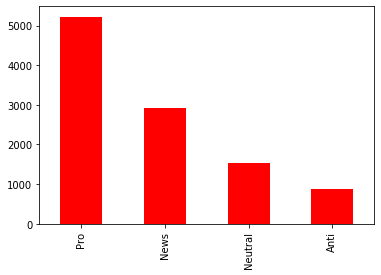

In [23]:
# Logisitc Regression
pd.DataFrame(le.inverse_transform(lr_y_pred))[0].value_counts().plot(kind='bar', color='red')

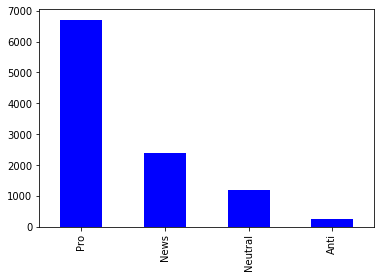

In [24]:
# Random Forest Classifier
pd.DataFrame(le.inverse_transform(rf_y_pred))[0].value_counts().plot(kind='bar', color='blue')

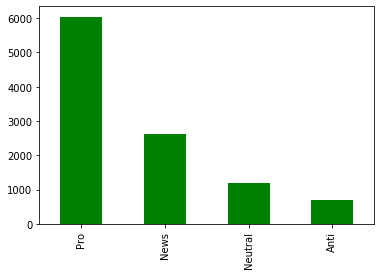

In [25]:
# LinearSVC()
pd.DataFrame(le.inverse_transform(svc_y_pred))[0].value_counts().plot(kind='bar', color='green')

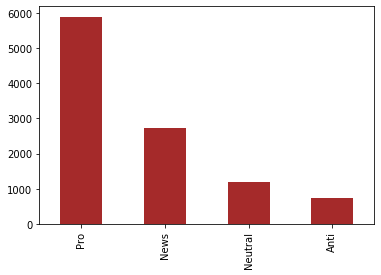

In [81]:
# SVM
pd.DataFrame(le.inverse_transform(svc2_y_pred))[0].value_counts().plot(kind='bar', color='brown')

###### - SVC models bring a similar prediction distributions as to the train data

#### Ensemble Predictions

In [100]:
ensemble_pred = []
for l, s, s2 in zip(lr_y_pred, svc_y_pred, svc2_y_pred):
    ensemble_pred.append(pd.DataFrame([l, s,s2])[0].mode())
e_predictions = pd.DataFrame(ensemble_pred)[0].apply(lambda x: int(x))

#### Distributions of sentiments

In [101]:
train_dist = pd.DataFrame(df_train.sentiment.value_counts()).sentiment.apply(lambda x: x/len(df_train)*100)
lr_dist = pd.DataFrame(pd.DataFrame(lr_y_pred)[0].value_counts())[0].apply(lambda x: x/len(df_test)*100)
rf_dist = pd.DataFrame(pd.DataFrame(rf_y_pred)[0].value_counts())[0].apply(lambda x: x/len(df_test)*100)
svc_dist = pd.DataFrame(pd.DataFrame(svc_y_pred)[0].value_counts())[0].apply(lambda x: x/len(df_test)*100)
svc_2dist = pd.DataFrame(pd.DataFrame(svc2_y_pred)[0].value_counts())[0].apply(lambda x: x/len(df_test)*100)
ensemble_dist = pd.DataFrame(pd.DataFrame(e_predictions)[0].value_counts())[0].apply(lambda x: x/len(df_test)*100)

In [102]:
sent_dist = pd.concat([lr_dist, svc_dist, svc_2dist, rf_dist, ensemble_dist], axis=1)
sent_dist.columns =['Logistic regression', 'LinearSVC()', 'Non-LinearSVC()', 'RandomForrestClassifier()', 'Ensemble'] 
sent_dist.set_index([pd.Index(sorted(type_labels, reverse=True))], inplace=True)
sent_dist['Train Data'] = sorted(train_dist, reverse=True)
sent_dist.head()

,Logistic regression,LinearSVC(),Non-LinearSVC(),RandomForrestClassifier(),Ensemble,Train Data
Pro,49.516404,57.301346,55.916935,63.626019,55.110943,53.922498
News,27.707188,24.767684,25.810734,22.738479,25.763323,23.010304
Neutral,14.574246,11.331310,11.283899,11.293381,11.843353,14.874518
Anti,8.202162,6.599659,6.988432,2.342120,7.282382,8.192680


#### Save Predictions 

In [106]:
final_predictions = le.inverse_transform(np.array(e_predictions))
def sentiment_map(x): 
    """Rename the sentiments to get better analyse the data"""
    if x == 'Neutral':   return 0       
    elif x == 'Pro': return 1     
    elif x == 'News': return 2    
    else: return -1  

In [107]:
df_test['sentiment'] = pd.DataFrame(final_predictions)[0].apply(sentiment_map)
df_test.head()

,message,tweetid,Tweet,sentiment
0,Europe will now be looking to China to make su...,169760,europe looking china make sure alone fighting ...,1
1,Combine this with the polling of staffers re c...,35326,combine polling staffer climate change woman r...,1
2,"The scary, unimpeachable evidence that climate...",224985,the scary unimpeachable evidence climate chang...,1
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,at_user at_user at_user at_user putin got jill...,0
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,rt at_user female orgasm cause global warming ...,0


In [92]:
df_test[['tweetid','sentiment']].to_csv('LK_climate_change_subm_Ensemble.csv', index=False) # Manual Submission